In [18]:
import argparse
import colorsys
import imghdr
import os
import random

import numpy as np
from keras import backend as K
from keras.models import load_model
from PIL import Image, ImageDraw, ImageFont

from yad2k.models.keras_yolo import yolo_eval, yolo_head


In [19]:
#初始化参数
model_path='model_data/yolo.h5'
assert model_path.endswith('.h5'), 'Keras model must be a .h5 file.'
anchors_path='model_data/yolo_anchors.txt'
classes_path='model_data/coco_classes.txt'
output_path='images/out'
score_threshold=.3
iou_threshold=.5

In [3]:
#创建输出图片的文件夹
if not os.path.exists(output_path):
    print('Creating output path {}'.format(output_path))
    os.mkdir(output_path)

In [4]:
#获取所有的类别和anchors
sess = K.get_session()
with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
#print(class_names)
#print(anchors)

In [5]:
#获取model,类别数，和anchors数
yolo_model = load_model(model_path)
num_classes = len(class_names)
num_anchors = len(anchors)

/home/xie/anaconda3/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
model_output_channels = yolo_model.layers[-1].output_shape[-1]
print('{} model, anchors, and classes loaded.'.format(model_path))

model_data/yolo.h5 model, anchors, and classes loaded.


In [7]:
# 生成 80 种颜色  画框框
hsv_tuples = [(x / len(class_names), 1., 1.)
              for x in range(len(class_names))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(
    map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
        colors))
random.seed(10101)  # Fixed seed for consistent colors across runs.
random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
random.seed(2016)  # Reset seed to default.

#print(len(colors))

In [8]:
# Generate output tensor targets for filtered bounding boxes.
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=score_threshold,
    iou_threshold=iou_threshold)


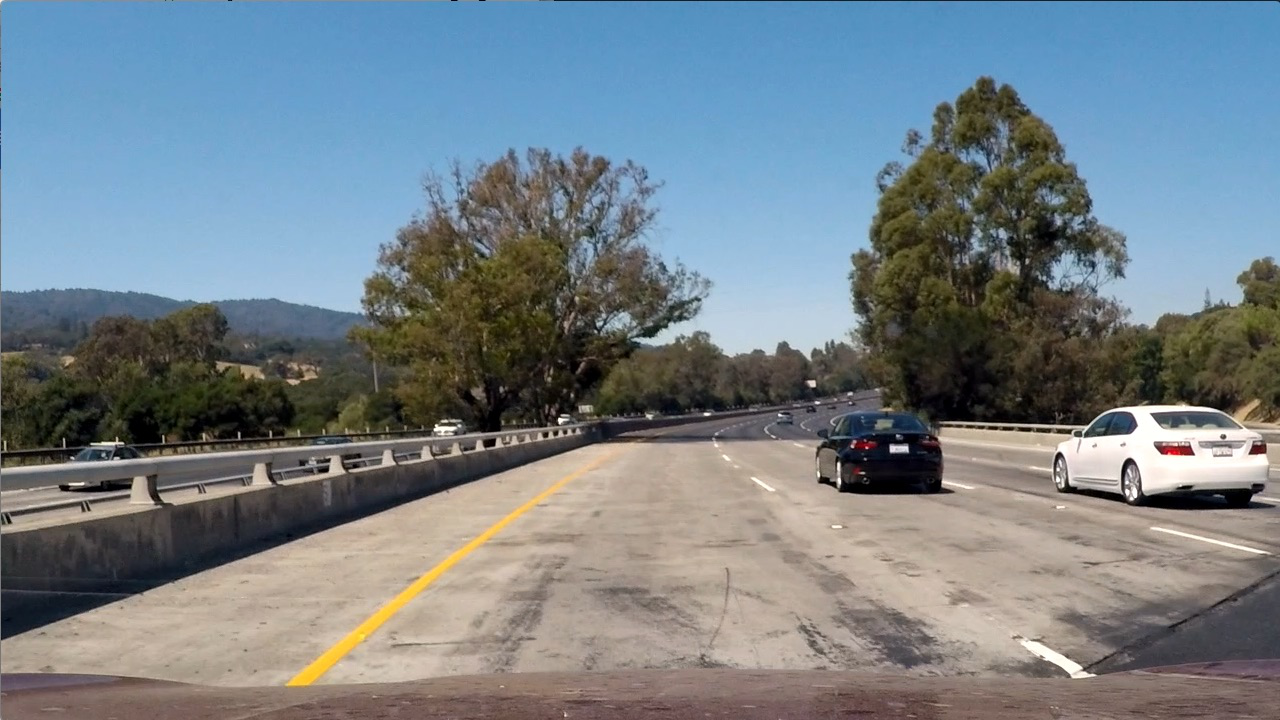

In [9]:
#读取图片
image_file = 'images/test1.jpg'
image = Image.open(image_file)
image

In [10]:
# Check if model is fully convolutional, assuming channel last order.
model_image_size = yolo_model.layers[0].input_shape[1:3]
print(model_image_size)
is_fixed_size = model_image_size != (None, None)
#将图像转化为numpy数组
if is_fixed_size:  # TODO: When resizing we can use minibatch input.
    resized_image = image.resize(
        tuple(reversed(model_image_size)), Image.BICUBIC)
    #resized_image.show()
    image_data = np.array(resized_image, dtype='float32')
    
#image_data

(608, 608)


In [11]:
image_data /= 255.
image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

In [12]:
out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                yolo_model.input: image_data,
                input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })
print(out_boxes)
print(out_scores)
print(out_classes)
print('Found {} boxes for {}'.format(len(out_boxes), image_file))

[[  412.58627319   822.10180664   488.4022522    941.12207031]
 [  404.99200439  1047.3770752    510.309021    1258.73022461]
 [  437.9670105     72.33633423   461.94216919   140.13868713]]
[ 0.79970837  0.79037011  0.4415518 ]
[2 2 2]
Found 3 boxes for images/test1.jpg


In [13]:
font = ImageFont.truetype(
            font='font/FiraMono-Medium.otf',
            size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
thickness = (image.size[0] + image.size[1]) // 300

car 0.44 (72, 438) (140, 462)
car 0.79 (1047, 405) (1259, 510)
car 0.80 (822, 413) (941, 488)


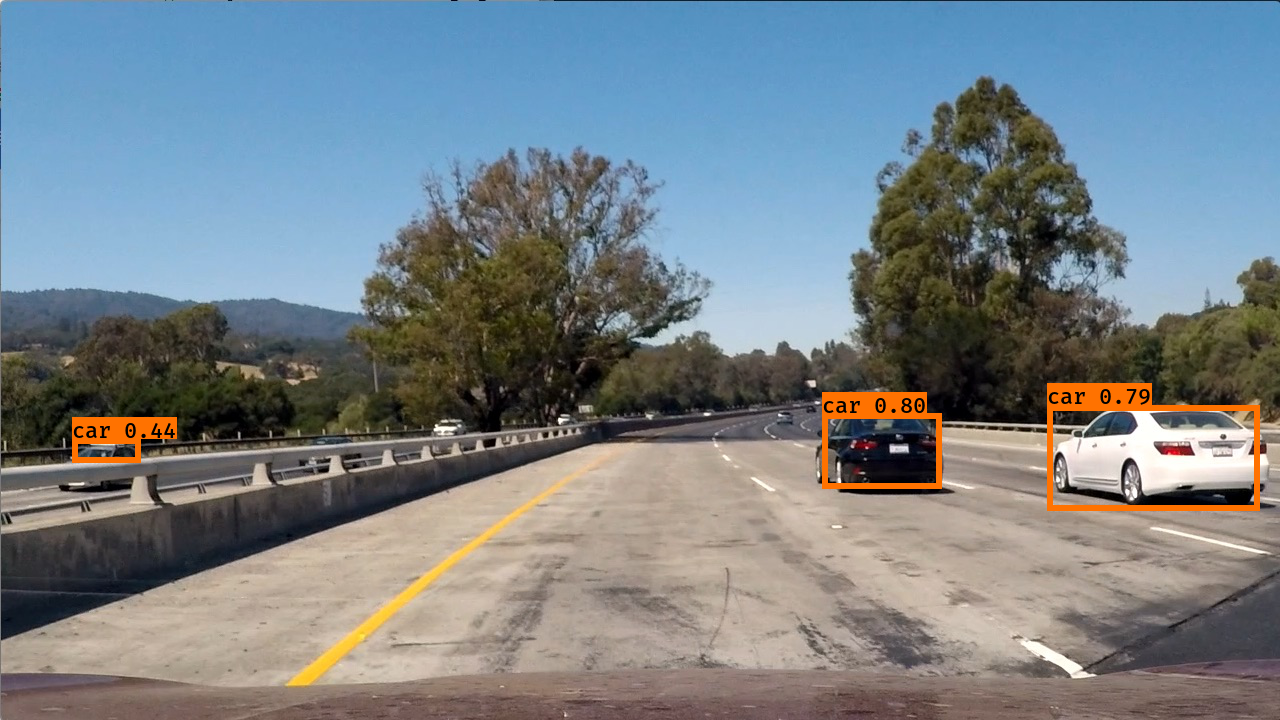

In [14]:
for i, c in reversed(list(enumerate(out_classes))):
    predicted_class = class_names[c]
    box = out_boxes[i]
    score = out_scores[i]
    label = '{} {:.2f}'.format(predicted_class, score)
    draw = ImageDraw.Draw(image)
    label_size = draw.textsize(label, font)
    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
    print(label, (left, top), (right, bottom))
    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])
    #框出所有的目标
    for i in range(thickness):
        draw.rectangle(
            [left + i, top + i, right - i, bottom - i],
            outline=colors[c])
    #文字处上底色
    draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=colors[c])
    #添加文字 {类别 概率}
    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    del draw
image    


In [15]:
image.save(os.path.join(output_path, 'car.jpg'), quality=90)

In [15]:
def frame_func(image):
    #sess = K.get_session()
    image = Image.fromarray(image)
    resized_image = image.resize(
        tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                yolo_model.input: image_data,
                input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })
    font = ImageFont.truetype(
            font='font/FiraMono-Medium.otf',
            size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300
    tmp = np.array([])
    if out_classes.tolist()==[]:
        return np.array(image, dtype='float32')
    else:
        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = class_names[c]
            box = out_boxes[i]
            score = out_scores[i]
            label = '{} {:.2f}'.format(predicted_class, score)

            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)
            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            #print(label, (left, top), (right, bottom))
            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])
            #框出所有的目标
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=colors[c])
            #文字处上底色
            draw.rectangle(
                        [tuple(text_origin), tuple(text_origin + label_size)],
                        fill=colors[c])
            #添加文字 {类别 概率}
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw
        return np.array(image, dtype='float32')


In [16]:
from moviepy.editor import VideoFileClip
project_video_output = './shiyanshi_output.mp4'
clip1 = VideoFileClip("./shiyanshi.mp4")

In [17]:
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./shiyanshi_output.mp4
[MoviePy] Writing video ./shiyanshi_output.mp4


100%|██████████| 301/301 [00:27<00:00, 11.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./shiyanshi_output.mp4 

CPU times: user 11.7 s, sys: 684 ms, total: 12.4 s
Wall time: 27.8 s
